# regular solution:

While the chemical potential of a regular solution is defined as:
$$
\mu_{\mathrm{B}}^{\mathrm{E}} = \left(\frac{\partial G^{\mathrm{E}}}{\partial n_{\mathrm{B}}}\right)_p= k_{\mathrm{B}} T \ln \gamma_{\mathrm{B}}
$$

As result, a regular solution will comply with:
$$
\left(\frac{\partial\left(k_{\mathrm{B}} T \ln \gamma_{\mathrm{B}}\right)}{\partial T}\right)_p=0
$$
In other words:
$$
k_{\mathrm{B}} T \ln \gamma_{\mathrm{B}}= \mathrm{const.}
$$
which implies that $\gamma$ is a function of temperature in a regular solution


On the other hand, for an athermal solution:
$$
H^{\mathrm{E}}=\left(\frac{\partial\left( \frac{\Delta G^E}{T} \right)}{\partial( \frac{1}{T})}\right)_p=0
$$

$$
\left[\frac{\partial^2\left(\frac{G^{\mathrm{E}}}{T}\right)}{\partial n_{\mathrm{B}} \partial T}\right]_p = \frac{\partial}{\partial T}\left(\frac{1}{T} \frac{\partial G^{\mathrm{E}}}{\partial n_{\mathrm{B}}}\right)_p=0
$$

$$
\left(\frac{\partial \ln \gamma_B}{\partial T}\right)_p=0
$$

which implies that $\gamma$ is independent on temperature in an athermal solution


In [1]:
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cm
import scipy.constants
from math import pi, isinf
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings("ignore")

font = {'family': 'serif', 'size': 16}
plt.rc('font', **font)
plt.rc('text', usetex=True)

# Constants kb in the unit of kj/mol
GAS_CONSTANT = 8.314462618 * 10**(-3)

In [2]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad


def get_betadmua_dlnxa(saa: float, sab: float, sbb: float, xa: float) -> float:
    """
    Calculate the derivative of beta_mu_a with respect to ln(x_a).

    Parameters:
    saa (float): Parameter S_AA
    sab (float): Parameter S_AB
    sbb (float): Parameter S_BB
    xa (float): Mole fraction of component A

    Returns:
    float: The derivative of beta_mu_a with respect to ln(x_a)
    """
    xb = 1.0 - xa
    return 1.0 / (xb * saa + xa * sbb - 2 * (xa * xb) ** 0.5 * sab)

def mu_mol_frac(saa: np.ndarray, sab: np.ndarray, sbb: np.ndarray, xa: np.ndarray, x0: float, kbT: float) -> np.ndarray:
    """
    Calculate the integral of a function and its error.

    Parameters:
    saa, sab, sbb (np.ndarray): 2D arrays with shape (2, N), where the first row is S and the second row is S_error.
    xa (np.ndarray): 1D array with N elements.
    x0 (float): A constant.
    kbT (float): Boltzmann constant times temperature.

    Returns:
    np.ndarray: A 2D array where each row is [x_a, mu, mu_error].
    """
    
    logxa = np.log(xa)

    integrand = get_betadmua_dlnxa(saa[:,0],sab[:,0],sbb[:,0],xa)
    integrand_error = np.sqrt((xa**2*saa[:,1]**2 + 4*xa*(1-xa)*sab[:,1]**2 + 
                               (1-xa)**2*sbb[:,1]**2)/(xa*saa[:,0] + (1-xa)*sbb[:,0] - 2*sab[:,0]*(xa*(1-xa))**0.5)**4)   

    mask = ~np.isnan(integrand)
    int_func = interp1d(logxa[mask], integrand[mask], kind='linear',fill_value='extrapolate')
    int_error_func = interp1d(logxa[mask], integrand_error[mask], kind='linear',fill_value='extrapolate')

    # Calculate the integral using list comprehension
    x_mu_dataset = []
    for i, a in enumerate(logxa):
        mu_now = kbT * quad(int_func, np.log(x0), a)[0]
        mu_error_now = kbT * quad(int_error_func, np.log(x0), a)[0]
        mu_error_now /= np.sqrt(i) if i >= 1 else 1
        x_mu_dataset.append([xa[i], mu_now, abs(mu_error_now)])
    
    return np.asarray(x_mu_dataset)

def read_data(file_path: str) -> tuple:
    """
    Read a data file and extract several columns into numpy arrays.

    Parameters:
    file_path (str): The path to the data file.

    Returns:
    tuple: A tuple containing numpy arrays for x_eth, x_water, S_AA, S_AB, and S_BB.
    """
    data = pd.read_csv(file_path, sep=' ', skiprows=9, 
                       names=["x", "AA", "AA_err", "AB", "AB_err", "BB", "BB_err"], engine='python')
    x_eth = data['x'].values
    x_water = 1 - x_eth

    S_AA = data[['AA', 'AA_err']].values
    S_AB = data[['AB', 'AB_err']].values
    S_BB = data[['BB', 'BB_err']].values
    
    return x_eth, x_water, S_AA, S_AB, S_BB
    

def process_data_mu(file_path: str, T: float ) -> tuple:
    """
    Process data from a file and calculate gamma values.

    Parameters:
    file_path (str): The path to the data file.
    T (float): Temperature.

    Returns:
    tuple: A tuple containing numpy arrays for x_eth, gamma_eth_sum, and gamma_water_sum.
    """
    x_eth, x_water, S_AA, S_AB, S_BB = read_data(file_path)

    kbT = GAS_CONSTANT * T 
    excess_mu_eth_part = mu_mol_frac(S_AA, S_AB, S_BB, x_eth, 1, kbT)
    excess_mu_water_part = mu_mol_frac(S_BB, S_AB, S_AA, x_water, 1, kbT)

    # Calculate gamma and gamma_err in a single step
    #gamma_eth, gamma_eth_err = np.exp(excess_mu_eth_part[:, 1] / kbT) / x_eth, excess_mu_eth_part[:, 2] / kbT * np.exp(excess_mu_eth_part[:, 1] / kbT)
    #gamma_eth_sum = np.column_stack((gamma_eth, gamma_eth_err))
    
    #gamma_water, gamma_water_err = np.exp(excess_mu_water_part[:, 1] / kbT) / x_water, excess_mu_water_part[:, 2] / kbT * np.exp(excess_mu_water_part[:, 1] / kbT)
    #gamma_water_sum = np.column_stack((gamma_water, gamma_water_err))
    
    return x_eth, excess_mu_eth_part, excess_mu_water_part

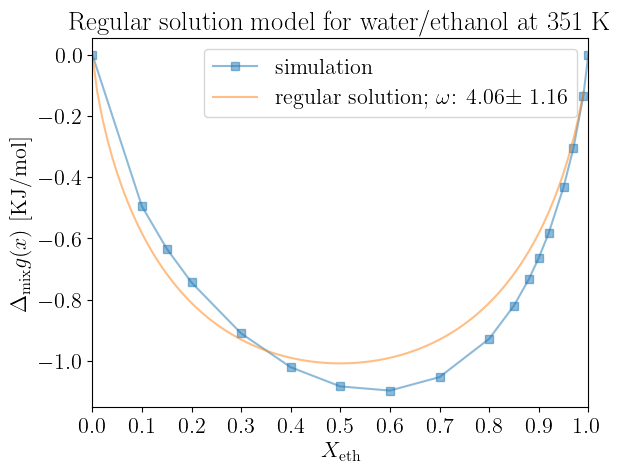

In [4]:
temperatures = [351]
file_paths = [f"/Users/xiaoyuwang/Downloads/GitHub/MD simulation for chemcial potential/NPT results/Ethanol + water mixture: Trappe-UA ethanol + Tip4p-ew water/Gromacs results/Liq_{T}K_1bar_gmx_trappeUA.txt" for T in temperatures]

# Use dictionary comprehension to store the results
x_eth_dataset = {}
gamma_eth_dataset = {}
gamma_water_dataset = {}

# Loop over each temperature and file path
for T, file_path in zip(temperatures, file_paths):
      x_eth_dp, excess_mu_eth_part, excess_mu_water_part = process_data_mu(file_path, T)


G_ex = x_eth_dp*excess_mu_eth_part[:, 1] + (1-x_eth_dp)*excess_mu_water_part[:, 1]

x_eth_dp = np.concatenate(([0], x_eth_dp, [1]))
G_ex = np.concatenate(([0], G_ex, [0]))

def regular_sol_firt_order(x, omega, T):
    return np.where((x == 0) | (x == 1), 0, (x * np.log(x) + (1-x) * np.log(1-x))*GAS_CONSTANT*T + omega * x * (1-x))

# Initial guess for parameter omega
initial_guess = 1.0

# Perform the fitting
popt, pcov = curve_fit(regular_sol_firt_order, x_eth_dp, G_ex)

# Get the optimized parameter omega
optimized_omega = np.around(popt[0], 2)
omega_error = np.around(np.sqrt(np.diag(pcov))[0], 2)

plt.plot(x_eth_dp, G_ex, marker='s', label="simulation", alpha = 0.5)

plt.plot(np.arange(0,1,0.01), regular_sol_firt_order(np.arange(0,1,0.01), optimized_omega, T),\
         label=f"regular solution; $\omega$: {optimized_omega}± {omega_error}",  alpha = 0.5)

plt.xticks(np.arange(0, 1.1, step=0.1))
plt.margins(x=0)
plt.ylabel(r"$ \Delta_{\mathrm{mix}} {g(x)} $ [KJ/mol]")
plt.xlabel("$X_\mathrm{eth}$")


plt.title(f"Regular solution model for water/ethanol at {T} K")
plt.legend()